## project_A

### remake of [https://towardsdatascience.com/graph-coloring-with-networkx](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4) in julia

In [1]:
import Pkg; Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Asztal/git/kicsikecske/notebook/graph-coloring-with-networkx`
Precompiling project...
  ✓ StatsBase
  1 dependency successfully precompiled in 2 seconds. 53 already precompiled.


In [3]:
using DelimitedFiles
using Graphs, GraphPlot, Colors
using DataFrames
using StatsBase

In [4]:
# read the data
d0,h0=readdlm(
  "synthetic_school_enrollment_data.csv",','; 
  header=true
)


(Any["Vanessa Harris" "Computer Science" … "False" "False"; "James Toliver" "Computer Science" … "False" "False"; … ; "Christine Lee" "Computer Science" … "False" "False"; "Bonita Senay" "Physics" … "False" "False"], AbstractString["" "Major" … "Tectonics" "Weather Systems"])

In [5]:
# convert the original data

# drop out the first three columns (name,major/minor)
# and convert it to a valid logical matrix
data=map(
  x->if x=="True"
    true
  elseif x=="False"
    false
  else
    throw(error("unknown value"))
  end, 
  d0[:,4:end]
)

header=h0[4:end]
num_of_students,num_of_courses=size(data)

(250, 40)

In [6]:
# build the graph:
# the nodes are the courses with an edge between them if there is a student visiting either.

# first, collect the set of students visiting each courses
S=[Set((1:num_of_students)[col]) for col in eachcol(data)]


# then, use the sets
G=Graph()
add_vertices!(G,num_of_courses)
for i in 1:num_of_courses-1, j in i+1:num_of_courses
  !isdisjoint(S[i],S[j]) && add_edge!(G,i,j)
end
ne(G),nv(G)

(273, 40)

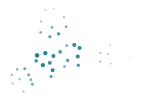

In [7]:
# plot the graph
deg=degree(G)
maxdeg=maximum(deg)
alpha=deg/maxdeg
nodefillc=[RGBA(0.1,0.5,0.6,a) for a in alpha]
gplot(
  G,
  nodesize=deg,
  edgelinewidth=0,
  nodefillc=nodefillc,
)

In [11]:
# as in networkX in Graph.jl there is a "builtin" method to generate 
# colorings, therefore we'll use it
# (qualify w/ Graphs. because it is not exported)
# it returns an object w/ num_colors and colors fields
# we need col.num_colors dates for the exams
@time the_coloring=Graphs.random_greedy_color(G,1000)


  0.006061 seconds (42.00 k allocations: 4.136 MiB)


Graphs.Coloring{Int64}(9, [7, 6, 8, 1, 5, 3, 4, 2, 4, 1  …  6, 4, 9, 8, 1, 6, 5, 4, 2, 3])

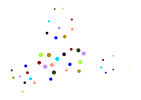

In [12]:
# plotting the graph w/ colors assigned
# shell layout would be better but 
# see https://github.com/JuliaGraphs/GraphPlot.jl/pull/186
dc=distinguishable_colors(the_coloring.num_colors, colorant"blue")

gplot(
  G,
  nodesize=deg,
  edgelinewidth=0,
  nodefillc=dc[the_coloring.colors],
)

In [14]:
# we need maxcolsize rooms
cm=the_coloring.colors|>countmap
mincolsize,maxcolsize=extrema(nc for (c,nc) in cm)

# build the final table
# exams for courses with the color 'k' will be held on the 'k'-th date given
table=fill("-",the_coloring.num_colors,maxcolsize) # indices for filling in
idx=fill(0,the_coloring.num_colors)
for i in 1:num_of_courses
  ri=the_coloring.colors[i]
  ci=(idx[ri]+=1)
  table[ri,ci]=header[i]
end

df=DataFrame(
  hcat("Exam-".*string.(1:the_coloring.num_colors),table),
  vcat("Exam","Room-".*string.(1:maxcolsize)))

  

Row,Exam,Room-1,Room-2,Room-3,Room-4,Room-5
,String,String,String,String,String,String
1,Exam-1,Biochemistry,Thermodynamics,Statistics I,Software Engineering,Ecology
2,Exam-2,Bioinformatics,Material Science,Linear Algebra,Programming in C++,Tectonics
3,Exam-3,Animal Behavior,Programming for Physics,Programming for Mathematics,Algorithms,Weather Systems
4,Exam-4,Genetics,Quantum Mechanics,Probability II,Data Science,Glaciology
5,Exam-5,Neurobiology,Classical Mechanics,Geometry,Physical Geology,-
6,Exam-6,Molecular Biology,Robotics,Probability I,Numerical Methods,Chemical Geology
7,Exam-7,Biology of the Cell,Linear Algebra for the Sciences,Calculus II,Programming Introduction,-
8,Exam-8,Evolution,Complex Systems,Statistics II,Artificial Inteligence,-
9,Exam-9,Nanotechnologies,Calculus I,Machine Learning,-,-
